In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
sys.path.append('/Users/gfabbian/Work/quasar_gaia/gaia-quasars-lss/code/')

from lensing_qso_cross_utils import *

rot = hp.Rotator(coord=['C','G'])

nside = 512#256
lmax = 3*nside-1 #1200
zmin = 0.9
zmax = 2.2

# Prepare CMb lensing maps and galactic cut masks.

I read and prepare the galactic masks that might be useful later

In [5]:
# read files

lensmask = hp.read_map('/Users/gfabbian/Work/PR4_variations/mask.fits')
galmask20 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=0)    
galmask40 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
galmask = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)  
galmask70 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)      
        
# degrade masks 
lensmask_lr = hp.ud_grade(lensmask,nside_out=nside)
lensmask_lr[lensmask_lr!=0]=1.

galmask70_lr = hp.ud_grade(galmask70,nside_out=nside)
galmask70_lr[galmask70_lr!=0]=1.

galmask_lr = hp.ud_grade(galmask,nside_out=nside)
galmask_lr[galmask_lr!=0]=1.

galmask40_lr = hp.ud_grade(galmask40,nside_out=nside)
galmask40_lr[galmask40_lr!=0]=1.

galmask20_lr = hp.ud_grade(galmask20,nside_out=nside)
galmask20_lr[galmask20_lr!=0]=1.


# create fsky 50% mask
try:
    testmask = nmt.mask_apodization(galmask_lr,15, apotype="C1")
    galmask50_lr = np.array(testmask)
    #threshold= 0.5 #for apo 10
    threshold= 0.3
    galmask50_lr[testmask<threshold]=0.
    galmask50_lr[testmask>threshold]=1
    galmask50 = hp.ud_grade(galmask50_lr,nside_out=2048)
    hp.write_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00_fsky50.fits',
        galmask50,overwrite=True,dtype=int)
except:
    galmask50=hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00_fsky50.fits')
    galmask50_lr = hp.ud_grade(galmask50,nside_out=nside)
  

In [6]:
# k maps for Planck DR4
klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[lmax+1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)
if nside != 2048:
    klr = hp.ud_grade(khr,nside_out=nside)
else:
    klr = khr

In [7]:
### k maps from Planck DR2 

klm_dr2 = hp.read_alm('/Users/gfabbian/Work/Planck/DR2/Lensing/dat_klm.fits')
khr_dr2=hp.alm2map(hp.almxfl(klm_dr2,fl),nside=2048,pol=False)
if nside != 2048:
    klr_dr2 = hp.ud_grade(khr_dr2,nside_out=nside)
else:
    klr_dr2 = khr_hdr2

In [8]:
### k maps from Planck DR3 
klm_dr3 = hp.read_alm('/Users/gfabbian/Work/Planck/DR3/COM_Lensing_4096_R3.00/MV/dat_klm.fits')
khr_dr3=hp.alm2map(hp.almxfl(klm_dr3,fl),nside=2048,pol=False)
if nside != 2048:
    klr_dr3 = hp.ud_grade(khr_dr3,nside_out=nside)
else:
    klr_dr3 = khr_hdr3

# SDSS DR16 data preparation

Reads photometric QSO eBOSS data set and applies redshift cut to match redshift band of Han+2019 https://arxiv.org/pdf/1809.04196.pdf . Compute the $dn/dz$ for theory predictions.

In [9]:
sdss=fits.open("../../sdss/DR16Q_v4.fits")
#sdss=fits.open("../../sdss/DR14Q_v4_4.fits")

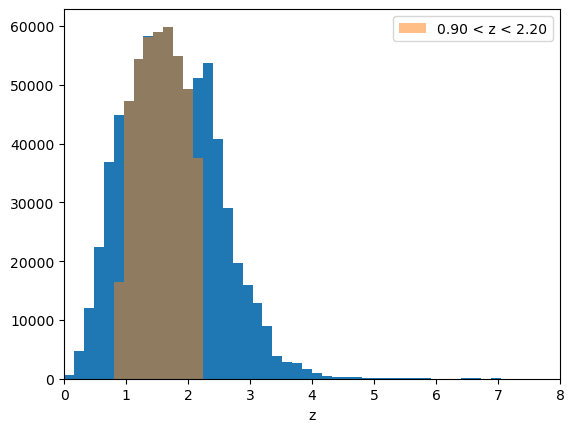

 New QSO in eBOSS samp 299238
 Old QSO in eBOSS samp 137304
 All QSO in eBOSS samp 436542
 All QSO in eBOSS cat  749749


In [10]:
try:
    # select only safest QSO
    qso_mask = sdss[1].data['IS_QSO_FINAL']==1
except:
    qso_mask = np.ones(len(sdss[1].data['Z']),dtype=bool)
    
z=sdss[1].data['Z']

pl.hist(z[z>0],bins=50,range=(0,8))

zmask=(z>zmin) & (z<zmax)
zmask = zmask & qso_mask
z=z[zmask]
ra = sdss[1].data['RA'][zmask]
dec= sdss[1].data['dec'][zmask]


pl.hist(z,bins=50,alpha=0.5,range=(0,8),label='%.2f < z < %.2f'%(zmin,zmax))
pl.xlabel("z")
pl.xlim(0,8)
pl.legend()
pl.show()

nqso_sdss = len(z)
try:
    mask_old = (((sdss[1].data['IS_QSO_DR7Q']>0) | (sdss[1].data['IS_QSO_DR12Q']>0)))[zmask]
    mask_eboss = (~mask_old)# & (qso_mask[zmask])
    print(" New QSO in eBOSS samp %ld\n"%np.sum(mask_eboss),"Old QSO in eBOSS samp %ld\n"%np.sum(mask_old),\
          "All QSO in eBOSS samp %ld\n"%np.sum(zmask),
          "All QSO in eBOSS cat ",np.sum(qso_mask))
except:
    mask_old = qso_mask[zmask]
    mask_eboss = mask_old
    print(" All QSO in DR14 samp %ld\n"%np.sum(mask_eboss),\
          "All QSO in DR14 cat ",np.sum(qso_mask))    

Computes counts map and catalog split to compute jackknife tests

In [11]:
sc = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')
l = gs.l.value
b = gs.b.value
l[l<0] = 360+l[l<0]

In [12]:

m_dr16_sdss=make_counts(nside,l[mask_old],b[mask_old])
m_dr16_eboss=make_counts(nside,l[mask_eboss],b[mask_eboss])
m_dr16=make_counts(nside,l,b)

split_reshuffle = np.arange(nqso_sdss)
np.random.shuffle(split_reshuffle)
m1_dr16=make_counts(nside,(l[split_reshuffle])[0::2],(b[split_reshuffle])[0::2])
m2_dr16=make_counts(nside,(l[split_reshuffle])[1::2],(b[split_reshuffle])[1::2])



Shows new eBOSS quasar wrt to old SDSS QSO catalogs. Note the old QSO split contain some extra data from reprocessed old catalogs with new DR16 pipeline

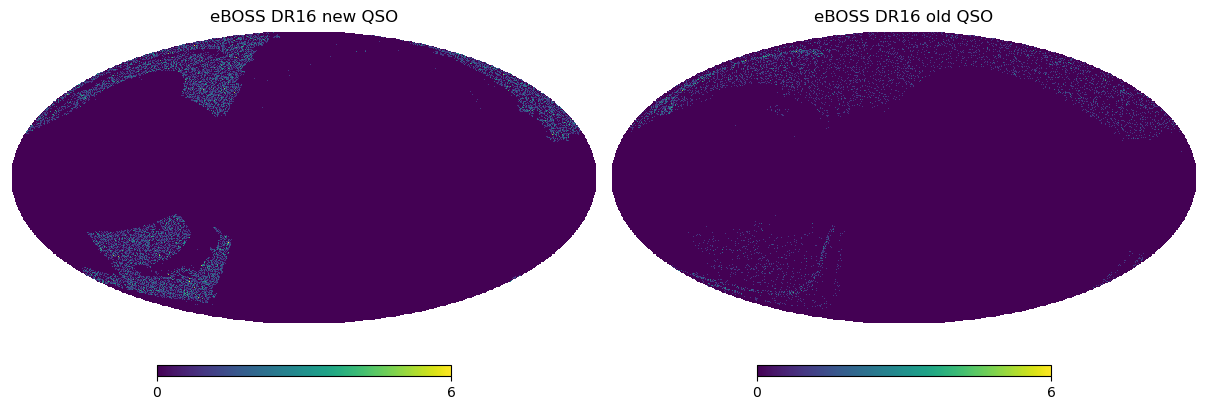

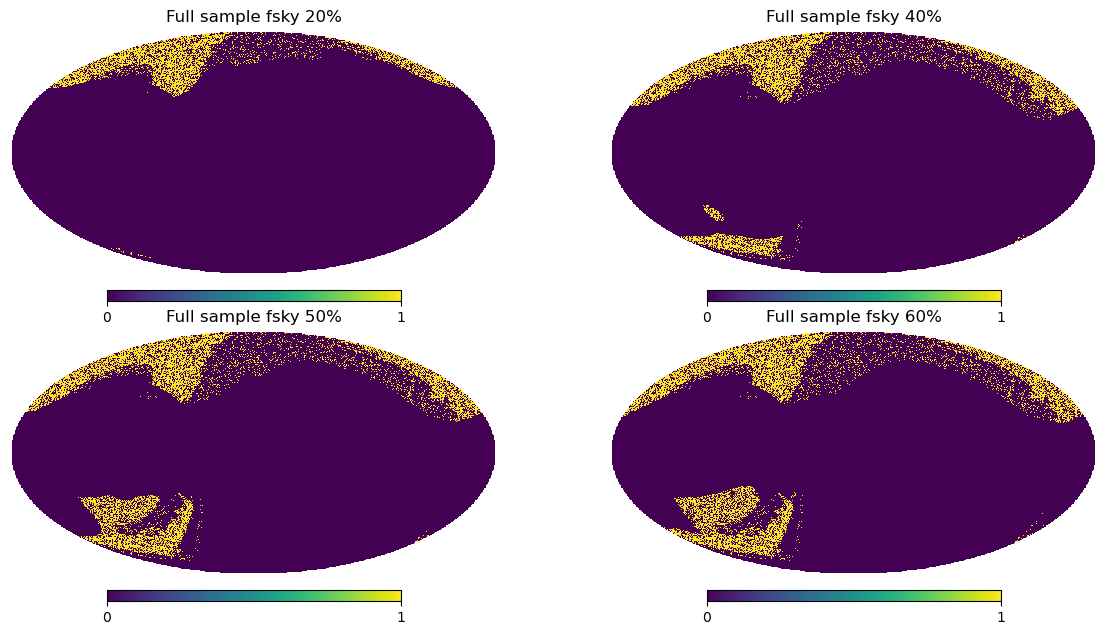

In [13]:
pl.figure(figsize=(12,8))
hp.mollview(m_dr16_eboss,title='eBOSS DR16 new QSO',sub=121)
hp.mollview(m_dr16_sdss,title='eBOSS DR16 old QSO',sub=122)
pl.show()

pl.figure(figsize=(12,6))
hp.mollview(galmask20_lr*(m_dr16>0),title='Full sample fsky 20%',sub=221)
hp.mollview(galmask40_lr*(m_dr16>0),title='Full sample fsky 40%',sub=222)
hp.mollview(galmask50_lr*(m_dr16>0),title='Full sample fsky 50%',sub=223)
hp.mollview(galmask_lr*(m_dr16>0),title='Full sample fsky 60%',sub=224)
#hp.mollview(galmask_lr*m,title='Full sample',min=0,max=17)
#hp.mollview(galmask40_lr*m,title='Full sample',min=0,max=17)
#hp.mollview(galmask20_lr*m,title='Full sample',min=0,max=17)
pl.show()


### Extinction test

Wecompute the photometric catalog footprint and also the total extinction map. As it can be seen the southersn hemnisphere is more contaminated by dust and it is removed by more aggressive galactic masks as it can be seen comparing the plots above with the ones below.



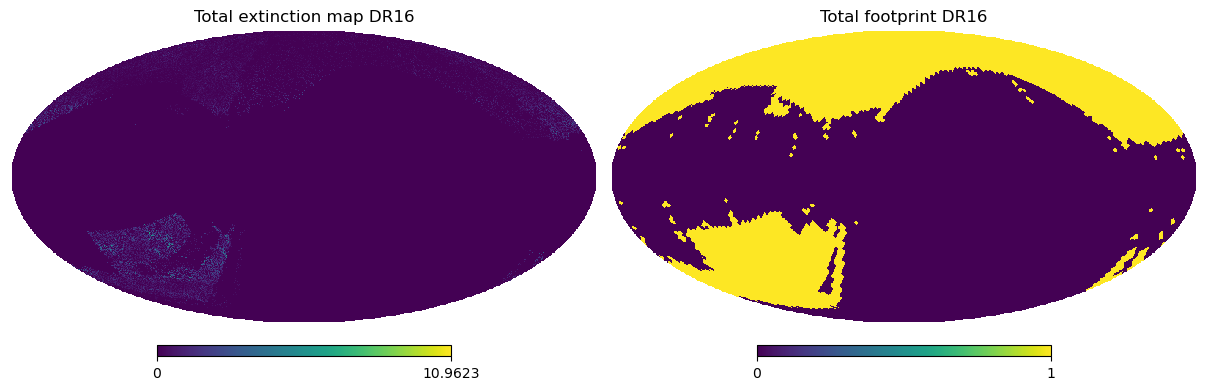

In [14]:
### define tota extinction map as sum of Exctinction values
ext = np.sum(sdss[1].data['EXTINCTION'],axis=1)[zmask]
ext[ext<0]=0.
m_dr16_ext=make_counts(nside,l[ext>0],b[ext>0],ext[ext>0])

footprint_dr16 = hp.ud_grade(m_dr16,nside_out=32)
footprint_dr16[footprint_dr16>0]=1

pl.figure(figsize=(12,4))
hp.mollview(m_dr16_ext,sub=121,title='Total extinction map DR16')
hp.mollview(footprint_dr16,sub=122,norm='hist',title='Total footprint DR16')
pl.show()

# eBOSS QSO clustering data DR16 and DR14

Now we do the same thing for the clustering spectroscopic data.  Note the analysis on the old SDSS footprint from the photometric survey has already been done in Leisted+2015 etc and the majority of the quasar now lies in the eBOSS data set. We therefore decide to drop for the time being the photometric data set. It seems also not trivial to manage a data set with so much difference in depth. 

We define as clustering sample as the spectroscopic observation data set.

In [17]:
eboss_n=fits.open("../../sdss/eBOSS_QSO_clustering_data-NGC-vDR16.fits")
eboss_s=fits.open("../../sdss/eBOSS_QSO_clustering_data-SGC-vDR16.fits")

z_eboss=np.append(eboss_n[1].data['Z'],eboss_s[1].data['Z'])
zmask_eboss=((z_eboss>zmin) & (z_eboss<zmax))

ra_eboss = np.append(eboss_n[1].data['RA'],eboss_s[1].data['RA'])[zmask_eboss]
dec_eboss= np.append(eboss_n[1].data['DEC'],eboss_s[1].data['DEC'])[zmask_eboss]

nqso_eboss = len(ra_eboss)

sc_eboss = SkyCoord(ra=ra_eboss, dec=dec_eboss, unit='deg', frame='icrs', equinox='J2000.0')
gs_eboss = sc_eboss.transform_to(frame='galactic')
l_eboss = gs_eboss.l.value
b_eboss = gs_eboss.b.value
l_eboss[l_eboss<0] = 360+l_eboss[l_eboss<0]

# combines systematics, completeness and redshift weight
weight_n = eboss_n[1].data['WEIGHT_SYSTOT']*eboss_n[1].data['WEIGHT_NOZ']*eboss_n[1].data['WEIGHT_CP']
weight_s = eboss_s[1].data['WEIGHT_SYSTOT']*eboss_s[1].data['WEIGHT_NOZ']*eboss_s[1].data['WEIGHT_CP']
systot_eboss = np.append(weight_n,weight_s)[zmask_eboss]


In [19]:

eboss_n14=fits.open("../../sdss/data_DR14_QSO_N.fits")
eboss_s14=fits.open("../../sdss/data_DR14_QSO_S.fits")

z_eboss14=np.append(eboss_n14[1].data['Z'],eboss_s14[1].data['Z'])
zmask_eboss14=((z_eboss14>zmin) & (z_eboss14<zmax))

ra_eboss14 = np.append(eboss_n14[1].data['RA'],eboss_s14[1].data['RA'])[zmask_eboss14]
dec_eboss14= np.append(eboss_n14[1].data['DEC'],eboss_s14[1].data['DEC'])[zmask_eboss14]

nqso_eboss14 = len(ra_eboss14)

sc_eboss14 = SkyCoord(ra=ra_eboss14, dec=dec_eboss14, unit='deg', frame='icrs', equinox='J2000.0')
gs_eboss14 = sc_eboss14.transform_to(frame='galactic')
l_eboss14 = gs_eboss14.l.value
b_eboss14 = gs_eboss14.b.value
l_eboss14[l_eboss14<0] = 360+l_eboss14[l_eboss14<0]

# combines systematics, completeness and redshift weight
weight_n14 = eboss_n14[1].data['WEIGHT_SYSTOT']*eboss_n14[1].data['WEIGHT_NOZ']*eboss_n14[1].data['WEIGHT_CP']
weight_s14 = eboss_s14[1].data['WEIGHT_SYSTOT']*eboss_s14[1].data['WEIGHT_NOZ']*eboss_s14[1].data['WEIGHT_CP']
systot_eboss14 = np.append(weight_n14,weight_s14)[zmask_eboss14]


In [20]:
# DR16
m_eboss=make_counts(nside,l_eboss,b_eboss)
m_eboss_systot=make_counts(nside,l_eboss,b_eboss,systot_eboss)

split_reshuffle = np.arange(nqso_eboss)
np.random.shuffle(split_reshuffle)
np.random.shuffle(split_reshuffle)

m1_eboss=make_counts(nside,(gs_eboss.l.value[split_reshuffle])[0::2],(gs_eboss.b.value[split_reshuffle])[0::2])
m2_eboss=make_counts(nside,(gs_eboss.l.value[split_reshuffle])[1::2],(gs_eboss.b.value[split_reshuffle])[1::2])

m1_eboss_systot=make_counts(nside,(gs_eboss.l.value[split_reshuffle])[0::2],
                            (gs_eboss.b.value[split_reshuffle])[0::2],systot_eboss[::2])
m2_eboss_systot=make_counts(nside,(gs_eboss.l.value[split_reshuffle])[1::2],
                            (gs_eboss.b.value[split_reshuffle])[1::2],systot_eboss[1::2])

#DR14
m_eboss14=make_counts(nside,l_eboss14,b_eboss14)

split_reshuffle14 = np.arange(nqso_eboss14)
np.random.shuffle(split_reshuffle14)
np.random.shuffle(split_reshuffle14)

m1_eboss14=make_counts(nside,(gs_eboss14.l.value[split_reshuffle14])[0::2],(gs_eboss14.b.value[split_reshuffle14])[0::2])
m2_eboss14=make_counts(nside,(gs_eboss14.l.value[split_reshuffle14])[1::2],(gs_eboss14.b.value[split_reshuffle14])[1::2])


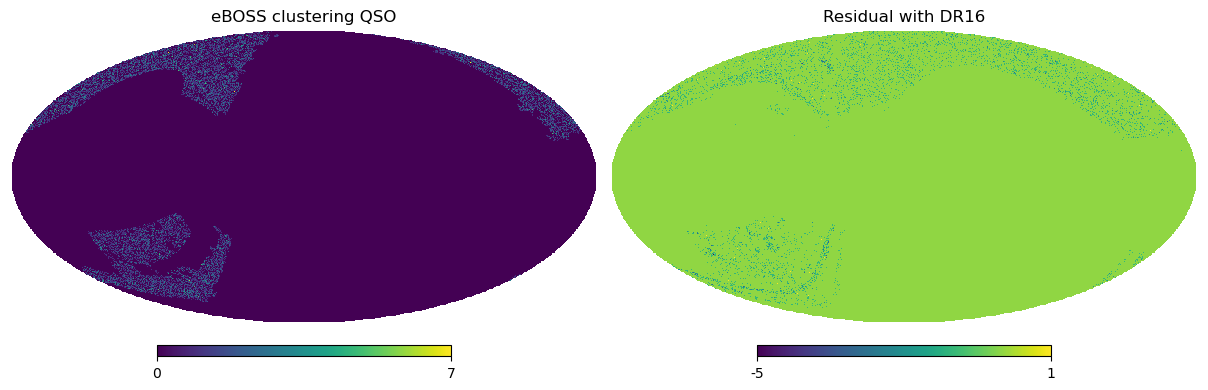

# QSO eBOSS clustering sample DR16 327480
# QSO eBOSS clustering sample DR14 142017
# QSO eBOSS DR16 total      sample 436542


In [21]:

pl.figure(figsize=(12,4))
hp.mollview(m_eboss,title='eBOSS clustering QSO',sub=121)
#hp.mollview(m_dr16,title='eBOSS DR16 QSO',sub=122)
hp.mollview(m_eboss-m_dr16,title='Residual with DR16',sub=122)
pl.show()
print("# QSO eBOSS clustering sample DR16",nqso_eboss)
print("# QSO eBOSS clustering sample DR14",nqso_eboss14)
print("# QSO eBOSS DR16 total      sample",nqso_sdss)



### Compute footprint and $dn/dz$

the clustering and photometric sample do not have very different $dn/dz$ compare to the photometric sample

In [22]:
footprint = hp.ud_grade(m_eboss,nside_out=32)
footprint[footprint>0]=1.
footprint=hp.ud_grade(footprint,nside_out=nside)

footprint14 = hp.ud_grade(m_eboss14,nside_out=32)
footprint14[footprint14>0]=1.
footprint14=hp.ud_grade(footprint14,nside_out=nside)

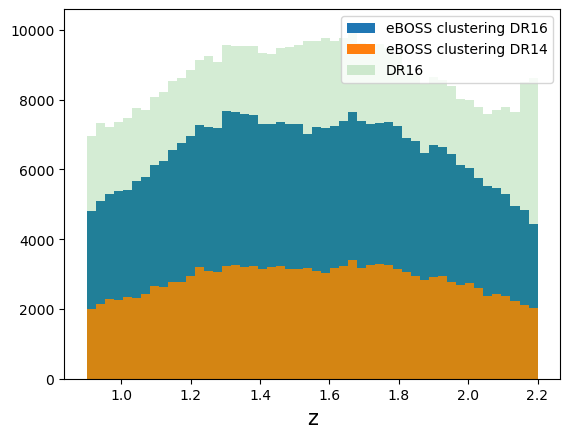

In [23]:
dndz_eboss=pl.hist(z_eboss[zmask_eboss],bins=50,density=False,range=(0.9,2.2),label='eBOSS clustering DR16')
dndz_eboss14=pl.hist(z_eboss14[zmask_eboss14],bins=50,density=False,range=(0.9,2.2),label='eBOSS clustering DR14')
dndz_dr16=pl.hist(z,bins=50,alpha=0.2,density=False,range=(0.9,2.2),label='DR16')

pl.xlabel('z',size=15)
pl.legend()
pl.show()

dndz_eboss=[np.diff(dndz_eboss[1])+dndz_eboss[1][:-1],dndz_eboss[0]]
dndz_eboss14=[np.diff(dndz_eboss14[1])+dndz_eboss14[1][:-1],dndz_eboss14[0]]
dndz_dr16=[np.diff(dndz_dr16[1])+dndz_dr16[1][:-1],dndz_dr16[0]]

# read dn/dz and normalize it
dndz_eboss[1]/=np.trapz(dndz_eboss[1],dndz_eboss[0])
dndz_eboss14[1]/=np.trapz(dndz_eboss14[1],dndz_eboss14[0])
dndz_dr16[1]/=np.trapz(dndz_dr16[1],dndz_dr16[0])


# Theory calculation

QSO are known to have a bias strongly evolving with redshift from original SDSS studies. We retrieve the data of the model and implement it as $b(z)$ in the theoretical curve calculation and compare it with a constant bias evaluated at an effective redshift.

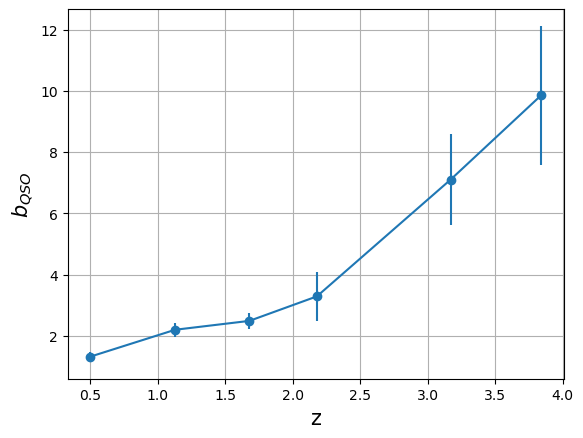

In [4]:
# Measured bias from SDSS,  includes data and error of Shen+2008 
# (https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1656/pdf)
#The positive points include only non-negative data points in the fit from correlation function.
# data are in the format z,b,b_error

bz_qso_th_positive = np.array([[0.50,1.32 ,0.17 ],[1.13 ,2.31 ,0.22],[1.68,2.96 ,0.26 ],[2.18,4.69 ,0.70 ],
                               [3.17,7.76 ,1.44 ],[3.84,12.96,2.09 ]])
bz_qso_th = np.array([[0.50,1.32,0.17 ],[1.13 ,2.20,0.23 ],[1.68 ,2.49,0.27 ],[2.18 ,3.29,0.79 ],
                      [3.17,7.10,1.48],[3.84,9.85,2.27]])

# NB for future analysis, scale dependent bias of matter tracers due to non-linear evolution should be close to 
# universal


pl.errorbar(bz_qso_th[:,0],bz_qso_th[:,1],bz_qso_th[:,2],marker='o')
pl.xlabel("z",size=15)
pl.ylabel("$b_{QSO}$",size=15)
pl.grid()
pl.show()

We then define CAMB interface for a Planck18 cosmology and the $dn/dz$ of the photometric quasar sample of DR16 as (for which we implement the aforementioned two models of the QSO bias) as well as the spectroscopic clustering data set for DR16 and DR14 (used in older studies e.h. Han+2019 https://arxiv.org/pdf/1809.04196.pdf). 

In [52]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


def init_pars(do_magnification_bias=False):

    pars = camb.CAMBparams()
    lmax=4*nside #1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 300
    pars.SourceTerms.counts_lensing = do_magnification_bias  
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = True #weird problems at times
    pars.SourceTerms.counts_radial   = True # negligible at l<10
    pars.SourceTerms.counts_timedelay = True # negligible
    pars.SourceTerms.counts_ISW = True #negligible
    pars.SourceTerms.counts_velocity = True #negligible
    pars.SourceTerms.counts_potential = True #negligible
    pars.SourceTerms.counts_evolve = True # not sure what this is
    
    pars.Accuracy.LensingBoost = 2.0
    pars.Accuracy.NonlinSourceBoost = 2.0
    pars.Accuracy.BesselBoost = 2.0
    pars.Accuracy.LimberBoost = 2.0
    pars.Accuracy.SourceLimberBoost = 2.0
    return pars 

# QSO clustering
pars = init_pars()
##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
b_quasar=2#2.35
W_i=np.array(dndz_eboss[1])
z_i=np.array(dndz_eboss[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z_i)), z=z_i, W=W_i,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 

# QSO clustering b(z)
pars_bz = init_pars()
W_i_bz=np.array(dndz_eboss[1])
z_i_bz=np.array(dndz_eboss[0])
pars_bz.SourceWindows = [SplinedSourceWindow(bias_z=np.interp(z_i_bz,bz_qso_th[:,0],bz_qso_th[:,1]), z=z_i_bz, W=W_i_bz,source_type='counts',dlog10Ndm = 0.0)]
results_bz = camb.get_results(pars_bz)
cls_bz = results_bz.get_source_cls_dict(raw_cl=True) 


# QSO DR16
pars_dr16 = init_pars()
b_quasar_dr16=2#2.35
W_i_dr16=np.array(dndz_dr16[1])
z_i_dr16=np.array(dndz_dr16[0])
pars_dr16.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar_dr16*np.ones(len(z_i_dr16)), z=z_i_dr16, W=W_i_dr16,source_type='counts',dlog10Ndm = 0.0)]
results_dr16 = camb.get_results(pars_dr16)
cls_dr16 = results_dr16.get_source_cls_dict(raw_cl=True) 

# QSO clustering DR14
pars_dr14 = init_pars()
b_quasar_dr14=2#2.35
W_i_dr14=np.array(dndz_eboss14[1])
z_i_dr14=np.array(dndz_eboss14[0])
pars_dr14.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar_dr14*np.ones(len(z_i_dr14)), z=z_i_dr16, W=W_i_dr14,source_type='counts',dlog10Ndm = 0.0)]
results_dr14 = camb.get_results(pars_dr14)
cls_dr14 = results_dr14.get_source_cls_dict(raw_cl=True) 



Including the $b(z)$ model gives results equivalent to assuming an effective constant bias of $b\sim 2.43$ as the best-fit value of the Han+2019 paper.  

Below we show the results. Note we have included all the relativistic correction terms except the magnification bias which is most likely negligible (e.g. Sherwin+2012 says that for DR8 SDSS-XDQSO the magnification bias parameter parameter $s=dlog_{10} N/dm = 0.043$ and should give negative corrections to the largest scales). The redshift term is the one giving the enhanced steepeness at the larges scales in the cross-correlation compared to the slope of the $C_\ell^{gg}$ and lensing power spectrum (dominated by the density terms).

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_86468/2593899653.py:4: RuntimeWarning: divide by zero encountered in divide
  d2p=1/p2d
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_86468/2593899653.py:25: RuntimeWarning: invalid value encountered in divide
  rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))


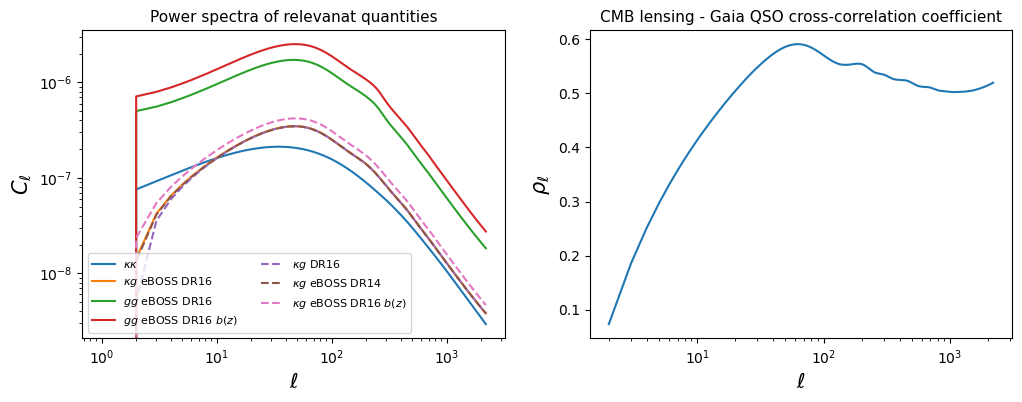

In [54]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$ eBOSS DR16') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$ eBOSS DR16') 
pl.loglog(ls,cls_bz['W1xW1'],label='$gg$ eBOSS DR16 $b(z)$') 
pl.loglog(ls,cls_dr16['PxW1']*p2k,label='$\kappa g$ DR16',ls='--')
pl.loglog(ls,cls_dr14['PxW1']*p2k,label='$\kappa g$ eBOSS DR14',ls='--')
pl.loglog(ls,cls_bz['PxW1']*p2k,label='$\kappa g$ eBOSS DR16 $b(z)$',ls='--')
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.title("Power spectra of relevanat quantities",size=11)
pl.legend(ncol=2,fontsize=8)


# compute correlation coefficient
rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.subplot(1,2,2)
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=11)
pl.show()

# Power spectrum analysis

To compare with the Han+2019 paper we use their same binning scheme with inverse variance and flat weighting scheme. We adopt preferentialky the inverse variance in the following. We consider different lensing map to test for possible stystematics.

In [26]:
# defines binning

lmin=30
delta_b=78
binning = define_binning(lmin,lmax,delta_b,nside,'ivar')    
lb = binning.get_effective_ells()

lmin=30
delta_b=78
binning_flat = define_binning(lmin,lmax,delta_b,nside,'flat')    
lb_flat = binning_flat.get_effective_ells()


### DR16 clustering x PR4 lensing 

We use the standard map and the one with the counts weighted by their systematic weights.

In [175]:
# DR16 x PR4
nbar_eboss = np.mean(m_eboss[footprint>0])

c = m_eboss/nbar_eboss -1
c[footprint==0]=0.

nbar1 = np.mean(m1_eboss[footprint>0])
c1 = m1_eboss/nbar1 -1
c1[footprint==0]=0.

nbar2 = np.mean(m2_eboss[footprint>0])
c2 = m2_eboss/nbar2 -1
c2[footprint==0]=0.

jk =(c2-c1)/2

apomask_eboss = nmt.mask_apodization(footprint,1, apotype="C2")
analysis_mask = apomask_eboss# avoids some of the auto correlation problem in bandpowers (more regular object)
clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned = \
    compute_master_crosscorr_mask(klr,c,c1,c2,jk,analysis_mask,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)

print("nbar eBOSS",nbar_eboss,nbar1,nbar2)

nbar eBOSS 0.7051922546857773 0.35259612734288864 0.35259612734288864


In [29]:
# DR16 x PR4 with systematics weights used in counts constructions.
nbar_eboss_systot = np.mean(m_eboss_systot[footprint>0])
c_systot = m_eboss_systot/nbar_eboss_systot -1

nbar1_systot = np.mean(m1_eboss_systot[footprint>0])
c1_systot = m1_eboss_systot/nbar1_systot -1

nbar2_systot = np.mean(m2_eboss_systot[footprint>0])
c2_systot = m2_eboss_systot/nbar2_systot -1

jk_systot =(c2_systot-c1_systot)/2

analysis_mask = apomask_eboss# avoids some of the auto correlation problem in bandpowers (more regular object)
clkg_sys,clgg_sys,clkk_sys,clkg1_sys,clg1g1_sys,clkg2_sys,clg2g2_sys,clg1g2_sys,clkgjk_sys,clgjk_sys,cl_gg_th_binned_sys,cl_kg_th_binned_sys,cl_kk_th_binned_sys = \
    compute_master_crosscorr_mask(klr,c_systot,c1_systot,c2_systot,jk_systot,analysis_mask,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)



Here conversely I construct weighting mask based either on the extinction weights or on the systematic weights. 

In [200]:
# DR16 x PR4 with systematics weights in the mask.
sys = hp.ud_grade(hp.ud_grade(m_eboss_systot,nside_out=32,power=2),nside_out=nside,power=2)
sys = sys/sys.max()

analysis_mask = apomask_eboss# avoids some of the auto correlation problem in bandpowers (more regular object)
clkg_sys2,clgg_sys2,clkk_sys2,clkg1_sys2,clg1g1_sys2,clkg2_sys2,clg2g2_sys2,clg1g2_sys2,clkgjk_sys2,clgjk_sys2,cl_gg_th_binned_sys2,cl_kg_th_binned_sys2,cl_kk_th_binned_sys2 = \
    compute_master_crosscorr_mask(klr,c,c1,c2,jk,analysis_mask*sys,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)

# DR16 x PR4 with dust extinction weights in the mask.

ext_w =np.array(m_dr16_ext)
ext_w[ext_w!=0] = 1/ext_w[ext_w!=0]
ext_w = hp.ud_grade(hp.ud_grade(ext_w,nside_out=32,power=2),nside_out=nside)
ext_w= ext_w/ext_w.max()
ext_w= ext_w*footprint/ext_w.max()


clkg_sysext,clgg_sysext,clkk_sysext,clkg1_sysext,clg1g1_sysext,clkg2_sysext,clg2g2_sysext,clg1g2_sysext,clkgjk_sysext,clgjk_sysext,cl_gg_th_binned_sysext,cl_kg_th_binned_sysext,cl_kk_th_binned_sysext = \
    compute_master_crosscorr_mask(klr,c,c1,c2,jk,analysis_mask*ext_w,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)


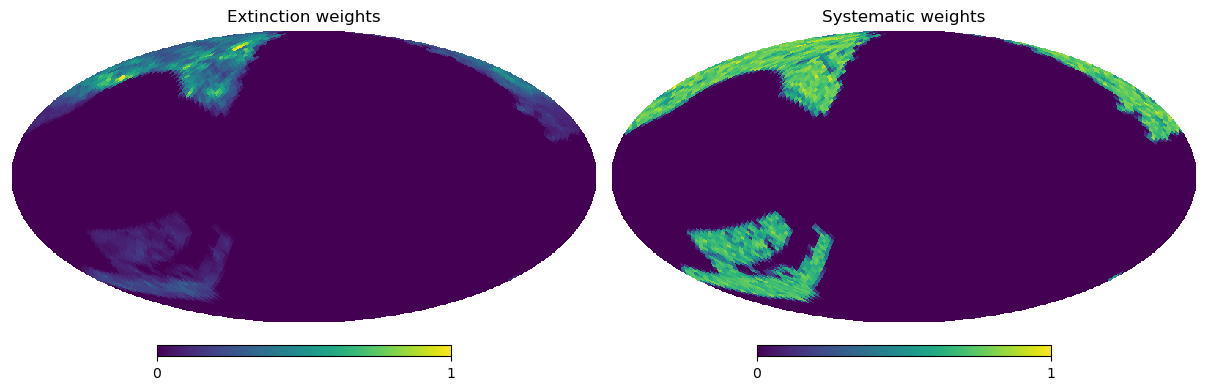

In [201]:
pl.figure(figsize=(12,4))
hp.mollview(ext_w,sub=121,title='Extinction weights')
hp.mollview(sys,sub=122,title='Systematic weights')
pl.show()


In [30]:
# DR16 X (PR2, PR3)
clkg_dr2,clgg_dr2,clkk_dr2,clkg1_dr2,clg1g1_dr2,clkg2_dr2,clg2g2_dr2,clg1g2_dr2,clkgjk_dr2,clgjk_dr2,cl_gg_th_binned_dr2,cl_kg_th_binned_dr2,cl_kk_th_binned_dr2 = \
    compute_master_crosscorr_mask(klr_dr2,c,c1,c2,jk,analysis_mask,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)

clkg_dr3,clgg_dr3,clkk_dr3,clkg1_dr3,clg1g1_dr3,clkg2_dr3,clg2g2_dr3,clg1g2_dr3,clkgjk_dr3,clgjk_dr3,cl_gg_th_binned_dr3,cl_kg_th_binned_dr3,cl_kk_th_binned_dr3 = \
    compute_master_crosscorr_mask(klr_dr3,c,c1,c2,jk,analysis_mask,binning,lmax,cls['W1xW1'],cls['PxW1']*p2k)


### DR14 clustering x PR4

We repeat the same as abobve but also use Planck DR2 (same setup in Han+2019 that also used DR14) and DR3

In [31]:
# DR14 x PR4
nbar_eboss14 = np.mean(m_eboss14[footprint14>0])

c14 = m_eboss14/nbar_eboss14 -1

nbar1_eboss14 = np.mean(m1_eboss14[footprint14>0])
c1_14 = m1_eboss14/nbar1_eboss14 -1

nbar2_eboss14 = np.mean(m2_eboss14[footprint14>0])
c2_14 = m2_eboss14/nbar2_eboss14 -1

jk_14 =(c2_14-c1_14)/2

#apomask_eboss = nmt.mask_apodization(footprint_rnd,1, apotype="C2")
apomask_eboss14 = nmt.mask_apodization(footprint14,1, apotype="C2")
analysis_mask14 = apomask_eboss14# avoids some of the auto correlation problem in bandpowers (more regular object)
clkg14,clgg14,clkk14,clkg114,clg1g114,clkg214,clg2g214,clg1g214,clkgjk14,clgjk14,cl_gg_th_binned14,\
    cl_kg_th_binned14,cl_kk_th_binned14 = compute_master_crosscorr_mask(klr,c14,c1_14,c2_14,jk_14,analysis_mask14,
                                                                    binning,lmax,cls_dr14['W1xW1'],cls_dr14['PxW1']*p2k)
print("nbar eBOSS DR14",nbar_eboss14,nbar1_eboss14,nbar2_eboss14)

nbar eBOSS DR14 0.5796801528213166 0.2898421172936259 0.2898380355276907


In [32]:
# DR14 w/ PR2 to mimick Han+2019

#analysis_mask14_dr2 = analysis_mask14
analysis_mask14_dr2 = footprint14
clkg14_dr2,clgg14_dr2,clkk14_dr2,clkg114_dr2,clg1g114_dr2,clkg214_dr2,clg2g214_dr2,clg1g214_dr2,clkgjk14_dr2,\
clgjk14_dr2,cl_gg_th_binned14_dr2,cl_kg_th_binned14_dr2,cl_kk_th_binned14_dr2 = \
    compute_master_crosscorr_mask(klr_dr2,c14,c1_14,c2_14,jk_14,analysis_mask14_dr2,
        binning_flat,lmax,cls_dr14['W1xW1'],cls_dr14['PxW1']*p2k)

In [33]:
# DR14 w/ PR3 

analysis_mask14_dr3 = analysis_mask14
#analysis_mask14_dr3 = footprint14
clkg14_dr3,clgg14_dr3,clkk14_dr3,clkg114_dr3,clg1g114_dr3,clkg214_dr3,clg2g214_dr3,clg1g214_dr3,clkgjk14_dr3,\
clgjk14_dr3,cl_gg_th_binned14_dr3,cl_kg_th_binned14_dr3,cl_kk_th_binned14_dr3 = \
    compute_master_crosscorr_mask(klr_dr3,c14,c1_14,c2_14,jk_14,analysis_mask14_dr3,
        binning,lmax,cls_dr14['W1xW1'],cls_dr14['PxW1']*p2k)

# Summary plots

In [35]:
def plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,
                 cl_kk_th_binned,lb=lb,delta_b=delta_b,nbar=nbar_eboss,analysis_mask=analysis_mask,xmin=10,
                 xmax=1000,ymin=1e-08,ymax=5e-06,lbmin=0,lbmax=None):
    
    beam=hp.pixwin(nside,lmax=lmax,pol=False)
    dkg = np.sqrt(np.abs(clkk*clgg) + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg1 = np.sqrt(np.abs(clkk*clg1g1) + clkg1**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg2 = np.sqrt(np.abs(clkk*clg2g2) + clkg2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkgjk = np.sqrt(np.abs(clkk*clgjk))/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg_th = np.sqrt(cl_kk_th_binned*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    
    if lbmax==None:
        lbmax=len(dkg)
    chi2=((clkg-cl_kg_th_binned)/dkg)[lbmin:lbmax]**2
    #print(chi2)
    chi2null=(clkg/dkg)[lbmin:lbmax]**2
    chi2jk=(clkgjk/dkgjk)[lbmin:lbmax]**2
    dof = len(chi2) -1
    snr = np.sqrt(np.cumsum(chi2null)[-1])
    snrth = np.sqrt(np.cumsum(clkg**2/dkg_th**2)[-1]) # uses theory error bar and not data-based estimates
    significance = np.sqrt(np.sum(chi2null) - np.sum(chi2))
    print("lmin",lb[lbmin],"dof",dof,"chi2null/dof %.3f"%(np.sum(chi2null)/dof))
    print("kg snr %.3f"%snr,'snr [th errors] %.3f'%snrth)
    print("kg chi2/dof    %.3f"%(np.sum(chi2)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2), dof))
    print("kg chi2/dof JK %.3f"%(np.sum(chi2jk)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2jk), dof))
    print("significance [delta chi2] %.3f"%significance)
    
    pl.figure(figsize=(12,8))
    pl.subplot(2,2,1)
    pl.errorbar(lb,clkg,dkg,label='kg',marker='o')
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk split',marker='x',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.errorbar(lb,clkk,label='kk')
    #pl.errorbar(lb,cl_kk_th_binned,label='th kk binned') # from input alms 
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(ymin,ymax)
    pl.xlim(xmin,xmax)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Full catalog results")
    #pl.show()
    
    # QSO splits CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,2)
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb,clkg1,dkg1,label='kg1 split',marker='o',ls='')
    pl.errorbar(lb+2,clkg2,dkg2,label='kg2 split',marker='o',ls='')
    #pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='o',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(ymin,ymax)
    pl.xlim(xmin,xmax)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Catalog split results")
    
    # QSO JACKKNIFE CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,3)
    pl.errorbar(lb,clkgjk,dkgjk,label='kgjk ',marker='o',ls='')
    pl.axhline(0,color='black')
    pl.xlim(xmin,xmax)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO Jakknife")
    
             
    # GALAXY AUTO    
    shot_noise = (lb*hp.nside2resol(nside)**2*1/nbar/lb)/beam[lb.astype(np.int32)]**2
    #shot_noise1 = lb*hp.nside2resol(nside)**2*1/nbar1/lb/beam[lb.astype(np.int32)]**2
    #shot_noise2 = lb*hp.nside2resol(nside)**2*1/nbar2/lb/beam[lb.astype(np.int32)]**2
    #print(shot_noise)
    pl.subplot(2,2,4)
    dgXg = np.sqrt(clg1g1*clg2g2 +clg1g2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    pl.errorbar(lb,clgg,label='gg')
    pl.errorbar(lb,clgg-clgjk,label='gg - gjk')
    pl.errorbar(lb,clg1g1,label='g1g1',ls='-')
    pl.errorbar(lb,clg2g2,label='g2g2',ls='--')
    pl.errorbar(lb,clg1g2,yerr=dgXg,label='g1g2',ls='--')
    pl.errorbar(lb,clgjk,label='gjk')
    #pl.errorbar(lb,shot_noise,color='black',label='gg shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned+shot_noise,color='black',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise1,color='green',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise2,color='red',label='gg th+shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned,label='th gg binned',color='black',ls='-.')
    #pl.errorbar(lb,(cl_gg_th_binned+clgjk),label='th gg binned +jk',color='black',ls='-.')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,6e-03)
    pl.xlim(xmin,xmax)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO auto")
    pl.show()

### DR16 x PR4

lmin 75.84661835748791 dof 18 chi2null/dof 5.879
kg snr 10.287 snr [th errors] 13.064
kg chi2/dof    0.760 PTE 0.7495703455735148
kg chi2/dof JK 1.257 PTE 0.2053982991200466
significance [delta chi2] 9.599


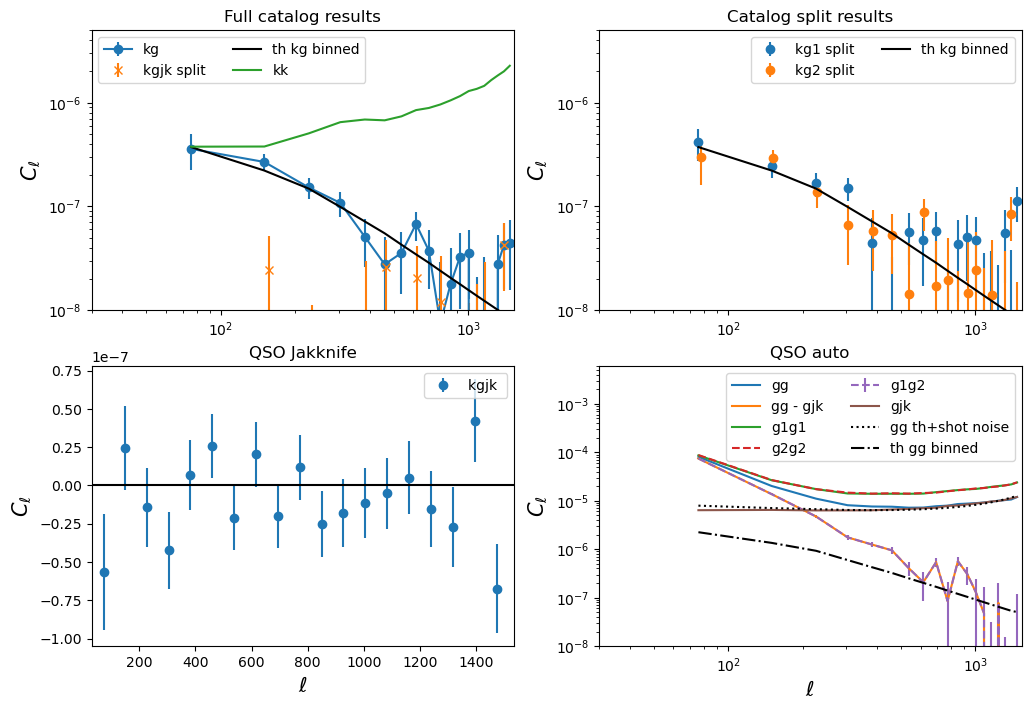

In [176]:
# DR16
plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned*(2.43/b_quasar)**2,
             cl_kg_th_binned*2.43/b_quasar,cl_kk_th_binned,nbar=nbar_eboss,xmin=lmin,xmax=lmax)

### DR14 x PR4

lmin 75.84661835748791 dof 18 chi2null/dof 3.808
kg snr 8.279 snr [th errors] 10.690
kg chi2/dof    1.429 PTE 0.10617484447507808
kg chi2/dof JK 2.380 PTE 0.0008453866381268327
significance [delta chi2] 6.543


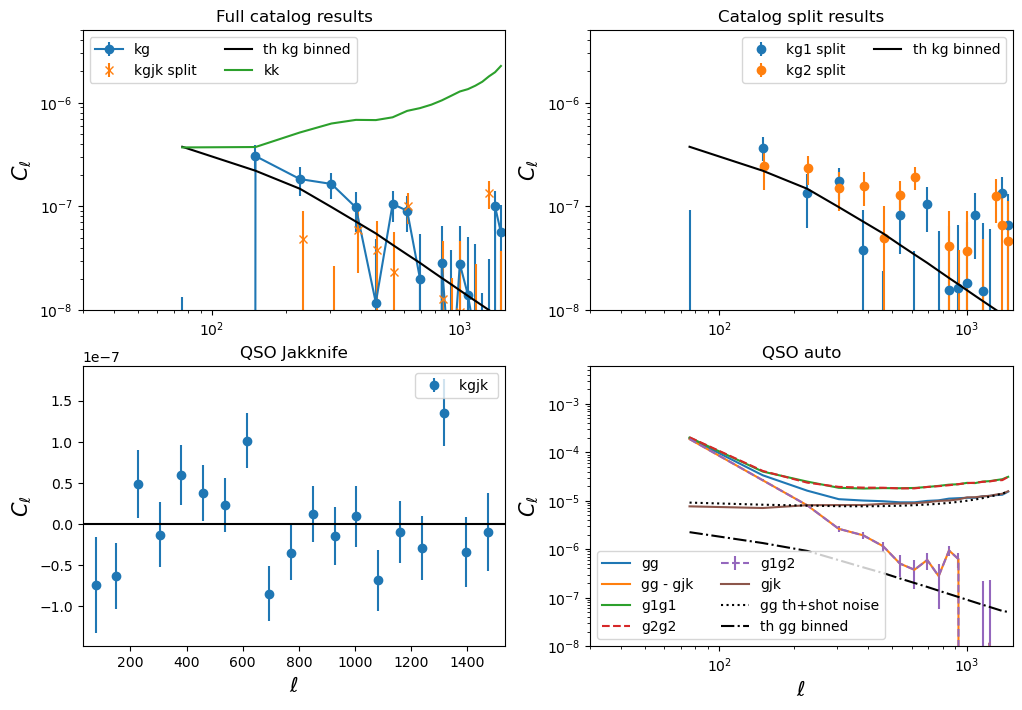

In [59]:
# DR14
#nbar = nbar_eboss14
plot_summary(clkg14,clgg14,clkk14,clkg114,clg1g114,clkg214,clg2g214,clg1g214,clkgjk14,clgjk14,cl_gg_th_binned14*(2.43/b_quasar)**2,
             cl_kg_th_binned14*2.43/b_quasar,cl_kk_th_binned14,nbar=nbar_eboss14,analysis_mask=analysis_mask14,xmin=lmin,xmax=lmax)

### DR14 x PR2 and comparison with Han+2019

This case tries to reproduce Hen+2019. I compare these results with the statistics computed from the digitized data points of the plot in the paper. 

The total significance is similar while the $\chi^2$ is slightly higher (16.8 vs ~12.9 quoted in the paper). Note also that the cross-correlation between CMB lensing and the jackknife catalog seems to fail in this case. I have not understood why at present.

lmin 68.50000000000011 dof 14 chi2null/dof 3.542
kg snr 7.042 snr [th errors] 10.156
kg chi2/dof    1.201 PTE 0.26633450527966085
kg chi2/dof JK 2.103 PTE 0.009111666220298353
significance [delta chi2] 5.725


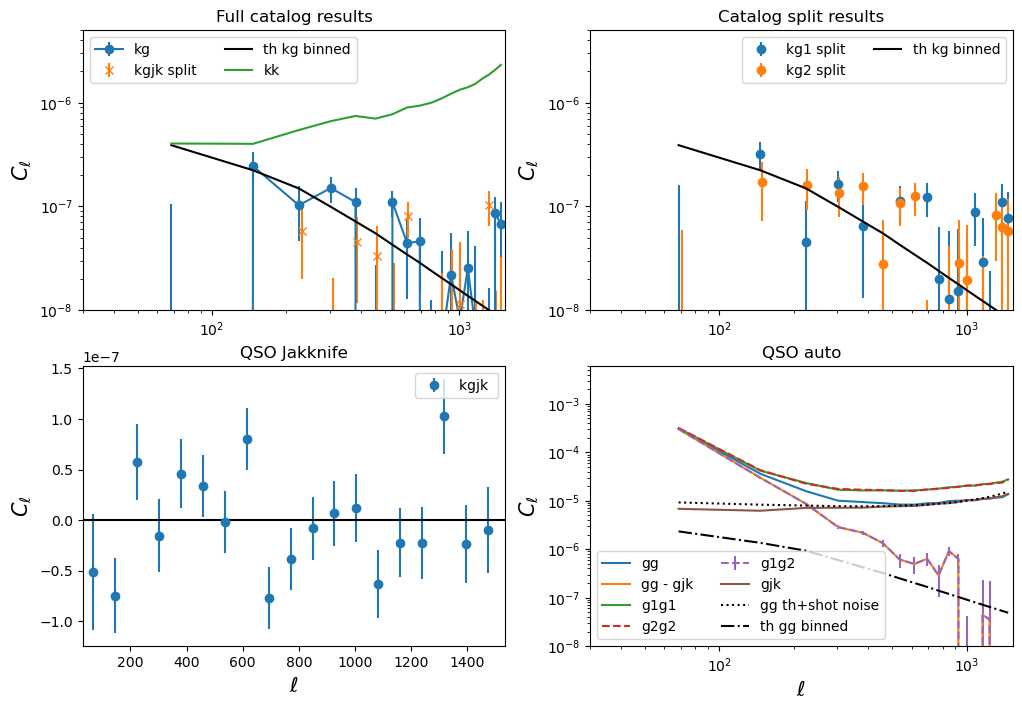

In [60]:
# DR14 x PR2 to redo Hen+2019
plot_summary(clkg14_dr2,clgg14_dr2,clkk14_dr2,clkg114_dr2,clg1g114_dr2,clkg214_dr2,clg2g214_dr2,clg1g214_dr2,clkgjk14_dr2,clgjk14_dr2,cl_gg_th_binned14_dr2*(2.43/b_quasar)**2,
             cl_kg_th_binned14_dr2*2.43/b_quasar,cl_kk_th_binned14_dr2,lb_flat,nbar=nbar_eboss14,analysis_mask=analysis_mask14_dr2,xmin=lmin,xmax=lmax,lbmax=-4)

I compare the results with the statistics computed from the digitized points extracted from the Hen+2019 paper. I recover the results and numbers of the paper in terms of total $\chi^2$ (5.97 vs 5.4) and detection significance (12.2 vs 12.9)

In [61]:
### load digitized old data 

dr14_old = np.loadtxt('../../sdss/sdss_analysis_dr14_2018.dat',delimiter=',',unpack=True)
dr14_oldth = np.loadtxt('../../sdss/sdss_analysis_dr14_2018_theory.dat',delimiter=',',unpack=True)


In [62]:
clkg14_old=dr14_old[1]*1e-07
dkg14_old = (dr14_old[2]-dr14_old[3])*1e-07/2

lbmin=0
chi2_old=((clkg14_old-cl_kg_th_binned[:-4]*2.43/2)/dkg14_old)[lbmin:]**2
chi2null_old=(clkg14_old/dkg14_old)[lbmin:]**2

dof = len(chi2_old) -1
snr_old = np.sqrt(np.cumsum(chi2null_old)[-1])
significance_old = np.sqrt(np.sum(chi2null_old) - np.sum(chi2_old))
print("lmin",lb[lbmin],"dof",dof,"chi2null/dof %.3f"%(np.sum(chi2null_old)/dof))
print("kg snr %.3f"%snr_old)
print("kg chi2/dof    %.3f"%(np.sum(chi2_old)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2_old), dof))
print("significance [delta chi2] %.3f"%significance_old)
print("chi2 %.3f"%(np.sum(chi2_old)))

lmin 75.84661835748791 dof 14 chi2null/dof 3.423
kg snr 6.923
kg chi2/dof    0.874 PTE 0.586936443951311
significance [delta chi2] 5.974
chi2 12.241


### $\kappa g$ Comparison plots

I compare the behaviour of the DR14 and DR16 releases with different version of the Planck lensing maps. The differences are mainly driven by the catalog version rather than the lensing version. 

* The systematics weights do not seem to give any significant results. Differences are of the order of few % in the bandpowers although some points at $\ell\approx 1000$ shift by a factor 2. Note I compute the oversendity from the weighted counts map (labelled SYS in the plots).

* If the systematic weights are included as weights in the mask they do not have large impact in cross but shift considerably the first points in the autospectrum of QSO. Using weights based on extinction values computed from the photometric sample provide similar effects but seem to be less effective (labelled SYS extinction in the plots). The cross is also more affected but likely the best thing to do here is to do deprojection.

* For DR16, Planck PR2 and PR3 (not shown) give essentially the same results. Difference with DR4 are only around $\ell \approx 600$. The errorbars between PR4 and PR3 are the same. The pipeline has inverse variance weighting binning of power spectrum. 

* For DR14 has slightly larger variations but overall PR3 is consistent with PR2 except on the second bin where it is consistent with PR4.

* For DR14 PR2 followed the recipe of the Han+2019 paper in terms of footprint calculation and binning (flat). It agrees with the point in the paper except some small variation after $\ell>800$ where there is agreement with PR4.



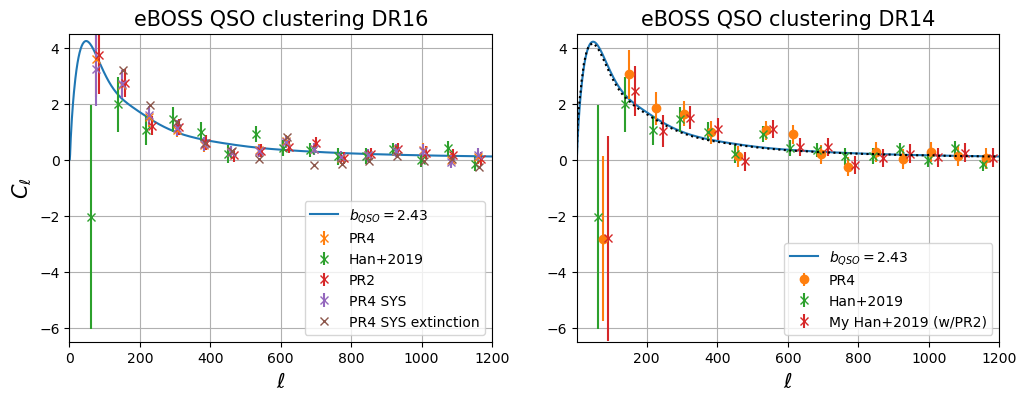

In [206]:
dkg = np.sqrt(clkk*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg_sys = np.sqrt(clkk_sys*clgg_sys + clkg_sys**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg_sys2 = np.sqrt(clkk_sys2*clgg_sys2 + clkg_sys2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask*sys))
dkg_dr2 = np.sqrt(clkk_dr2*clgg_dr2 + clkg_dr2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dkg_dr3 = np.sqrt(clkk_dr3*clgg_dr3 + clkg_dr3**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))

dkg14 = np.sqrt(clkk14*clgg14 + clkg14**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask14))
dkg14_dr2 = np.sqrt(clkk14_dr2*clgg14_dr2 + clkg14_dr2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask14_dr2))
dkg14_dr3 = np.sqrt(clkk14_dr3*clgg14_dr3 + clkg14_dr3**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask14_dr3))

pl.figure(figsize=(12,4))
pl.subplot(121)
pl.plot(ls,cls['PxW1']*p2k*2.43/b_quasar/1e-07,label='$b_{QSO}=2.43$')
#pl.plot(lb,cl_kg_th_binned*2.4/b_quasar/1e-07,ls='--')
pl.errorbar(lb,clkg/1e-07,dkg/1e-07,ls='',marker='x',label='PR4')
pl.errorbar(dr14_old[0]-7,dr14_old[1],(dr14_old[2]-dr14_old[3])/2,ls='',marker='x',label='Han+2019')
pl.errorbar(lb+7,clkg_dr2/1e-07,dkg_dr2/1e-07,ls='',marker='x',label='PR2')
pl.errorbar(lb,clkg_sys/1e-07,dkg_sys/1e-07,ls='',marker='x',label='PR4 SYS')
#pl.errorbar(lb+2,clkg_sys2/1e-07,dkg_sys/1e-07,ls='',marker='x',label='PR4 SYS weighting')
pl.errorbar(lb+2,clkg_sysext/1e-07,ls='',marker='x',label='PR4 SYS extinction')
#pl.errorbar(lb,clkg_dr3/1e-07,dkg_dr3/1e-07,ls='',marker='x',label='PR3')
pl.grid()
pl.ylim(-6.5,4.5)
pl.xlim(0,1200)
pl.title("eBOSS QSO clustering DR16",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.xlabel("$\ell$",size=15)
pl.legend(loc='lower right')


pl.subplot(122)
pl.plot(ls,cls_dr14['PxW1']*p2k*2.43/b_quasar/1e-07,label='$b_{QSO}=2.43$')
pl.errorbar(lb,clkg14/1e-07,dkg14/1e-07,ls='',marker='o',label='PR4')
pl.errorbar(dr14_old[0]-7,dr14_old[1],(dr14_old[2]-dr14_old[3])/2,ls='',marker='x',label='Han+2019')
pl.errorbar(lb_flat+20,clkg14_dr2/1e-07,dkg14_dr2/1e-07,ls='',marker='x',label='My Han+2019 (w/PR2)')
#pl.errorbar(lb,clkg14_dr3/1e-07,dkg14_dr3/1e-07,ls='',marker='x',label='PR3')
sort = np.argsort(dr14_oldth[0])
pl.errorbar(dr14_oldth[0][sort],dr14_oldth[1][sort],color='black',ls=':')
pl.grid()
pl.ylim(-6.5,4.5)
pl.xlim(1,1200)
pl.title("eBOSS QSO clustering DR14",size=15)
pl.xlabel("$\ell$",size=15)
pl.legend(loc='lower right')
pl.show()


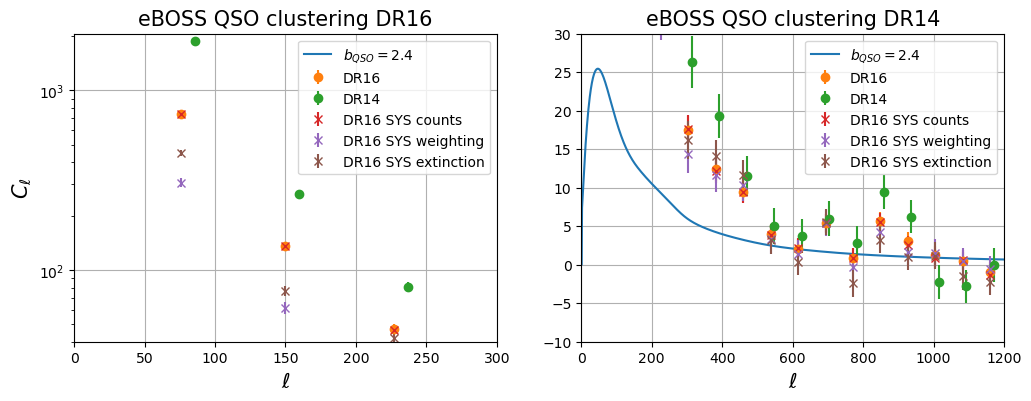

In [204]:
dgg = np.sqrt(clg1g1*clg2g2 + clg1g2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dgg_sys = np.sqrt(clg1g1_sys*clg2g2_sys + clg1g2_sys**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
dgg_sys2 = np.sqrt(clg1g1_sys2*clg2g2_sys2 + clg1g2_sys2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask*sys))
dgg14 = np.sqrt(clg1g114*clg2g214 + clg1g214**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask14))

pl.figure(figsize=(12,4))
pl.subplot(121)
pl.plot(ls,cls['W1xW1']*(2.43/b_quasar)**2/1e-07,label='$b_{QSO}=2.4$')
#pl.plot(lb,cl_kg_th_binned*2.4/b_quasar/1e-07,ls='--')
pl.errorbar(lb,clg1g2/1e-07,dgg/1e-07,ls='',marker='o',label='DR16')
pl.errorbar(lb+10,clg1g214/1e-07,dgg14/1e-07,ls='',marker='o',label='DR14')
pl.errorbar(lb,clg1g2_sys/1e-07,dgg_sys/1e-07,ls='',marker='x',label='DR16 SYS counts')
pl.errorbar(lb,clg1g2_sys2/1e-07,dgg_sys2/1e-07,ls='',marker='x',label='DR16 SYS weighting')
pl.errorbar(lb,clg1g2_sysext/1e-07,dgg_sys2/1e-07,ls='',marker='x',label='DR16 SYS extinction')
pl.grid()
#pl.ylim(-6.5,4.5)
pl.xlim(0,300)
pl.title("eBOSS QSO clustering DR16",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.xlabel("$\ell$",size=15)
pl.ylim(40,None)
pl.yscale("log")
pl.legend()

# DR14
pl.subplot(122)
pl.plot(ls,cls['W1xW1']*(2.43/b_quasar)**2/1e-07,label='$b_{QSO}=2.4$')

#pl.plot(lb,cl_kg_th_binned*2.4/b_quasar/1e-07,ls='--')
pl.errorbar(lb,clg1g2/1e-07,dgg/1e-07,ls='',marker='o',label='DR16')
pl.errorbar(lb+10,clg1g214/1e-07,dgg14/1e-07,ls='',marker='o',label='DR14')
pl.errorbar(lb,clg1g2_sys/1e-07,dgg_sys/1e-07,ls='',marker='x',label='DR16 SYS counts')
pl.errorbar(lb,clg1g2_sys2/1e-07,dgg_sys2/1e-07,ls='',marker='x',label='DR16 SYS weighting')
pl.errorbar(lb,clg1g2_sysext/1e-07,dgg_sys2/1e-07,ls='',marker='x',label='DR16 SYS extinction')
pl.grid()
#pl.ylim(-6.5,4.5)
pl.ylim(-10,30)
pl.xlim(0,1200)
pl.title("eBOSS QSO clustering DR14",size=15)
pl.xlabel("$\ell$",size=15)
pl.legend()
pl.show()

In [ ]:
# TODO work check results with RND catalog. 

# RND eBOSS catalogs

They contain many more objects. Need to understand how to use it to compute the average number of objects per pixel

In [190]:
eboss_nrnd =fits.open("../../sdss/eBOSS_QSO_clustering_random-NGC-vDR16.fits")
eboss_srnd =fits.open("../../sdss/eBOSS_QSO_clustering_random-SGC-vDR16.fits")
#
##eboss_nrnd =fits.open("../../sdss/random_DR14_QSO_N.fits")
##eboss_srnd =fits.open("../../sdss/random_DR14_QSO_S.fits")
#
z_eboss_rnd=np.append(eboss_nrnd[1].data['Z'],eboss_srnd[1].data['Z'])
zmask_eboss_rnd=((z_eboss_rnd>0.9) & (z_eboss_rnd<2.2))

ra_eboss_rnd = np.append(eboss_nrnd[1].data['RA'],eboss_srnd[1].data['RA'])[zmask_eboss_rnd]
dec_eboss_rnd= np.append(eboss_nrnd[1].data['DEC'],eboss_srnd[1].data['DEC'])[zmask_eboss_rnd]

nqso_eboss_rnd = len(z_eboss_rnd)

sc_eboss_rnd = SkyCoord(ra=ra_eboss_rnd, dec=dec_eboss_rnd, unit='deg', frame='icrs', equinox='J2000.0')
gs_eboss_rnd = sc_eboss_rnd.transform_to(frame='galactic')
l_eboss_rnd = gs_eboss_rnd.l.value
b_eboss_rnd = gs_eboss_rnd.b.value
l_eboss_rnd[l_eboss_rnd<0] = 360+l_eboss_rnd[l_eboss_rnd<0]
m_eboss_rnd = make_counts(nside,l_eboss_rnd,b_eboss_rnd)

In [269]:
m_eboss_rnd=make_counts(nside,l_eboss_rnd,b_eboss_rnd)

#split_reshuffle_rnd = np.arange(nqso_sdss_rnd)
#np.random.shuffle(split_reshuffle_rnd)
#m1_eboss_rnd=make_counts(nside,(gs_eboss_rnd.l.value[split_reshuffle_rnd])[0::2],(gs_eboss_rnd.b.value[split_reshuffle_rnd])[0::2])
#m2_eboss_rnd=make_counts(nside,(gs_eboss_rnd.l.value[split_reshuffle_rnd])[1::2],(gs_eboss_rnd.b.value[split_reshuffle_rnd])[1::2])

footprint_rnd = hp.ud_grade(hp.ud_grade(m_eboss_rnd>0,nside_out=32),nside_out=nside)
footprint_rnd[footprint_rnd>0]=1.

print("Median z eBOSS LSS RND",np.median(z_eboss_rnd[zmask_eboss_rnd]),
      "\nMedian z eBOSS LSS    ",np.median(z_eboss[zmask_eboss]),      
      "\nMean map eBOSS LSS RND",np.mean(m_eboss_rnd[footprint_rnd>0]),
      "\nMean map eBOSS LSS    ",np.mean(m_eboss[footprint>0]))

print("N QSO DR16",nqso_eboss,"DR16 RND",nqso_eboss_rnd,"Ratio DR16 RND/DR16",nqso_eboss_rnd/nqso_eboss)

Median z eBOSS LSS RND 1.5424496848133875 
Median z eBOSS LSS     1.5421701891155728 
Mean map eBOSS LSS RND 36.87338369373644 
Mean map eBOSS LSS     0.7051922546857773
N QSO DR16 327480 DR16 RND 18269659 Ratio DR16 RND/DR16 55.78862525955783
